# TRY hyperopt

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, fmin

In [2]:
# dirs
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

In [3]:
# read data
train = pd.read_pickle(os.path.join(input_dir, 'train.pkl'))
test = pd.read_pickle(os.path.join(input_dir, 'test.pkl'))
sample_submission = pd.read_csv(os.path.join(input_dir, 'sample_submission.csv'), dtype={'fullVisitorId': 'str'})

In [4]:
# divide train into development and validation
dev = train[train['date']<=datetime.datetime(2017,5,31)]
val = train[train['date']>datetime.datetime(2017,5,31)]

TODO: 
1. dateをLGBに入れると型の問題でエラーが出る

In [5]:
# shape data set for modelling
drop_X_cols = ['fullVisitorId', 'date', 'sessionId', 'visitId', 'visitStartTime', 'gclId', 'source']
def divide_y_X(df, drop_X_cols=drop_X_cols):
    y = df['transactionRevenue'].fillna(0)
    X = df.drop(['transactionRevenue']+drop_X_cols, axis=1)
    return y, X

dev_y, dev_X = divide_y_X(dev)
val_y, val_X = divide_y_X(val)
train_y, train_X = divide_y_X(train)
test_X = test.drop(drop_X_cols, axis=1)

In [6]:
# formatting pred np.array into Dataframe and grouping by 'fullVisitorId'
def format_as_submission(pred_val, val):
    
    # negative can not be in log
    pred_val[pred_val<0] = 0
    
    # to Dataframe
    pred_val_df = pd.DataFrame(
        {
            'fullVisitorId': val['fullVisitorId'],
            'PredictedLogRevenue': pred_val
        }
    )
    
    # grouping
    submission = pred_val_df.groupby('fullVisitorId')['PredictedLogRevenue'].sum()
    submission = submission.to_frame()
    submission['PredictedLogRevenue'] = np.log1p(submission['PredictedLogRevenue'])
    return submission

In [7]:
hyperopt_params = {
    'num_leaves': hp.uniform('num_leaves', 300, 700),
    'min_child_samples': hp.uniform('min_child_samples', 350, 500),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.7),
    'bagging_freq': hp.uniform('bagging_freq', 5, 8)
}

In [8]:
fit_params = {
    'early_stopping_rounds':100,
    'eval_set':[(val_X, np.log1p(val_y))],
    'eval_metric': 'rmse',
    'verbose': False
}

TODO: groupKfoldを導入する

In [9]:
# float to int
tobe_int_params = ['num_leaves', 'min_child_samples', 'bagging_freq']
def int_param_encoder(params):
    for param in tobe_int_params:
        if param in params:
            params[param] = int(params[param])
    return params

In [10]:
num_evals_i = 0
def objective(hyperopt_params):
    # パラメータを適切な型(int)に変換
    hyperopt_params = int_param_encoder(hyperopt_params)
    # モデルのインスタンス化
    model = lgb.LGBMRegressor(**hyperopt_params, n_estimators=1000, random_state=0)
    # trainデータを使ってモデルの学習
    model.fit(dev_X, np.log1p(dev_y), **fit_params)
    # validationデータを使用して、ラベルの予測
    pred_val = np.expm1(model.predict(val_X, num_iteration=model.best_iteration_))
    sbm_pred_val = format_as_submission(pred_val, val)
    sbm_val_y = format_as_submission(val_y, val)
    # 予測ラベルと正解ラベルを使用してRMSEを計算
    rmse_score = np.sqrt(mean_squared_error(sbm_val_y, sbm_pred_val))
    global num_evals_i
    num_evals_i += 1
    print('[{num_evals}] best_ite: {best_ite}\tRMSE: {rmse_score}'.format(num_evals=str(num_evals_i).zfill(4), rmse_score=rmse_score, best_ite=model.best_iteration_))
    return rmse_score

In [11]:
# iterationする回数
max_evals = 10
# 試行の過程を記録するインスタンス
trials = Trials()

best = fmin(
    # 最小化する値を定義した関数
    fn=objective,
    # 探索するパラメータのdictもしくはlist
    space=hyperopt_params,
    # どのロジックを利用するか、基本的にはtpe.suggestでok
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    # 試行の過程を出力
    verbose=-1,
    rstate=np.random.RandomState(0)
)

[0001] best_ite: 34	RMSE: 1.7639673409644376
[0002] best_ite: 45	RMSE: 1.7646609817483556
[0003] best_ite: 25	RMSE: 1.7659201189772962
[0004] best_ite: 87	RMSE: 1.7632026797733662
[0005] best_ite: 56	RMSE: 1.7628919597080215
[0006] best_ite: 34	RMSE: 1.7658431398107814
[0007] best_ite: 34	RMSE: 1.7649157083911051
[0008] best_ite: 87	RMSE: 1.7622163734634801
[0009] best_ite: 56	RMSE: 1.762541850292529
[0010] best_ite: 29	RMSE: 1.7618694614918167


In [12]:
best

{'bagging_freq': 7.563118519490496,
 'feature_fraction': 0.5576532968279372,
 'learning_rate': 0.2750548978068571,
 'min_child_samples': 475.67271404870667,
 'num_leaves': 473.4883220485384}

#### ①hyperoptで作ったモデルをそのままtest.csvの予測に用いる方法

In [13]:
# パラメータを適切な型(int)に変換
best = int_param_encoder(best)
# モデルのインスタンス化
model = lgb.LGBMRegressor(**best, n_estimators=1000, random_state=0)
# trainデータを使ってモデルの学習
model.fit(dev_X, np.log1p(dev_y), **fit_params)
# validationデータを使用して、ラベルの予測
pred_val = np.expm1(model.predict(val_X, num_iteration=model.best_iteration_))
sbm_pred_val = format_as_submission(pred_val, val)
sbm_val_y = format_as_submission(val_y, val)
# 予測ラベルと正解ラベルを使用してRMSEを計算
rmse_score = np.sqrt(mean_squared_error(sbm_val_y, sbm_pred_val))
print('RMSE: {rmse_score}, best_ite: {best_ite}'.format(rmse_score=rmse_score, best_ite=model.best_iteration_))

RMSE: 1.7621391634312917, best_ite: 34


In [14]:
pred_test = np.expm1(model.predict(test_X))
sbm_pred_test = format_as_submission(pred_test, test)
# save submission file
sbm_pred_test.to_csv(os.path.join(output_dir, 'submission_20181021_hp.csv'))

#### ②訓練データをtrain.csv全体にしてモデルを作成する

In [15]:
# make submission
best = int_param_encoder(best)
model_fulltrain = lgb.LGBMRegressor(**best, n_estimators=model.best_iteration_, random_state=0)
model_fulltrain.fit(train_X, np.log1p(train_y))
pred_test = np.expm1(model_fulltrain.predict(test_X))
sbm_pred_test = format_as_submission(pred_test, test)
# save submission file
sbm_pred_test.to_csv(os.path.join(output_dir, 'submission_20181021_fulltrain.csv'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f286b99dd68>]],
      dtype=object)

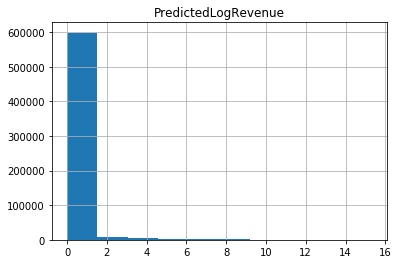

In [16]:
sbm_pred_test.hist()

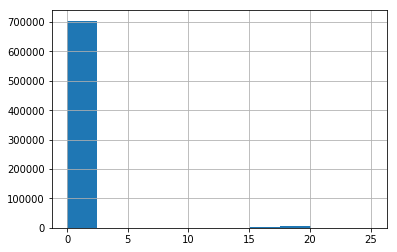

In [17]:
np.log(train.groupby('fullVisitorId')['transactionRevenue'].sum()+1).hist()

In [18]:
# trainとtestで重複していない値の数
col_diff_dict = {}
for col in test.columns:
    cnt = len(set(train[col].unique()) ^ set(test[col].unique()))
    col_diff_dict[col] = cnt
col_diff_dict

{'channelGrouping': 0,
 'date': 638,
 'fullVisitorId': 1316051,
 'sessionId': 1706608,
 'visitId': 1665797,
 'visitNumber': 84,
 'visitStartTime': 1667423,
 'browser': 95,
 'deviceCategory': 0,
 'isMobile': 0,
 'operatingSystem': 6,
 'city': 531,
 'continent': 0,
 'country': 15,
 'metro': 43,
 'networkDomain': 30150,
 'region': 214,
 'subContinent': 0,
 'bounces': 0,
 'hits': 91,
 'newVisits': 0,
 'pageviews': 89,
 'adContent': 57,
 'adNetworkType': 1,
 'gclId': 58925,
 'isVideoAd': 0,
 'page': 4,
 'slot': 1,
 'campaign': 29,
 'isTrueDirect': 0,
 'keyword': 4710,
 'medium': 0,
 'referralPath': 2720,
 'source': 296}